In [ ]:
!nvidia-smi -q -i 0 | grep "Product Name"

    Product Name                          : Tesla P100-PCIE-16GB


In [ ]:
!pip install -r '/content/gdrive/MyDrive/tfm/requirements.txt'

In [ ]:
model_saved_dir = '/content/gdrive/MyDrive/tfm/models/hiper-parametrizacion/VGG19-model-hiper'

train_dir = '/content/gdrive/MyDrive/tfm/version2/train_dir/'
test_dir = '/content/gdrive/MyDrive/tfm/version2/test_dir/'
val_dir = '/content/gdrive/MyDrive/tfm/version2/val_dir/'

In [ ]:
# Import libraries

import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

from keras.applications.vgg19 import VGG19

import keras_tuner as kt

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
im_width = 224
im_height = 224
channels=3

In [ ]:
sub_class = os.listdir(train_dir)
n_classes = len(sub_class)

In [ ]:
batch_size = 32

In [ ]:
train_datagen =  ImageDataGenerator(
    rescale=1/255.0, 
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    brightness_range=[0.5, 1.5]
)

train_generator = train_datagen.flow_from_directory(
  directory=train_dir,
  target_size=(im_width, im_height),
  batch_size=batch_size,
  color_mode='rgb',
  class_mode='categorical'
)

test_datagen = ImageDataGenerator(
    rescale=1/255.0 
)

test_generator = test_datagen.flow_from_directory(
  directory=test_dir,
  target_size=(im_width, im_height),
  batch_size=batch_size,
  color_mode='rgb',
  class_mode='categorical'
)


val_datagen = ImageDataGenerator(
    rescale=1/255.0 
)

val_generator = val_datagen.flow_from_directory(
  directory=val_dir,
  target_size=(im_width, im_height),
  batch_size=batch_size,
  color_mode='rgb',
  class_mode='categorical'
)

Found 41641 images belonging to 38 classes.
Found 10856 images belonging to 38 classes.
Found 5418 images belonging to 38 classes.


In [ ]:
def build_model(hp):
    
    inputs = tf.keras.Input(shape=(im_width, im_height, channels))

    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(im_width, im_height, channels))
    base_model.trainable = False
    #inputs = tf.keras.Input(shape=(im_width, im_height, channels))
    
    x = base_model(inputs)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    for i in range(hp.Int("num_layers", 1, 6)):
        x = layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=128, max_value=1024, step=64)
            ) (x)
        x = layers.BatchNormalization()(x)
        if hp.Boolean("dropout"):
          #x = layers.Dropout(rate=0.3)(x)
          drop_rate = hp.Choice('drop_rate_' + str(i),[0.0, 0.3])
          x = layers.Dropout(rate=drop_rate)(x)
    
    preds = layers.Dense(n_classes, activation='softmax')(x)
    model = Model(inputs = base_model.input, outputs = preds)

    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(loss="categorical_crossentropy", 
                  #optimizer="Adam", 
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    return model

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss')
checkpoint = keras.callbacks.ModelCheckpoint(model_saved_dir, save_best_only=True, monitor='val_loss')

In [ ]:
epochs = 5
batch_size = 32

step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size

In [ ]:
tuner = kt.tuners.RandomSearch(
    build_model,
    objective='val_loss',
    executions_per_trial=2,
    max_trials=4,
    overwrite=True)

80150528/80134624 [==============================] - 0s 0us/step


In [ ]:
%%time

tuner.search(train_generator,
             validation_data=val_generator,
             verbose=1, 
             epochs=epochs,
             callbacks=[early_stopping])


Trial 4 Complete [01h 52m 43s]
val_loss: 0.818832665681839

Best val_loss So Far: 0.5613376498222351
Total elapsed time: 13h 24m 27s
INFO:tensorflow:Oracle triggered exit
CPU times: user 7h 9min 14s, sys: 11min 39s, total: 7h 20min 53s
Wall time: 13h 24min 27s


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 13
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 6, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': None}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 1024, 'step': 64, 'sampling': None}
units_5 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

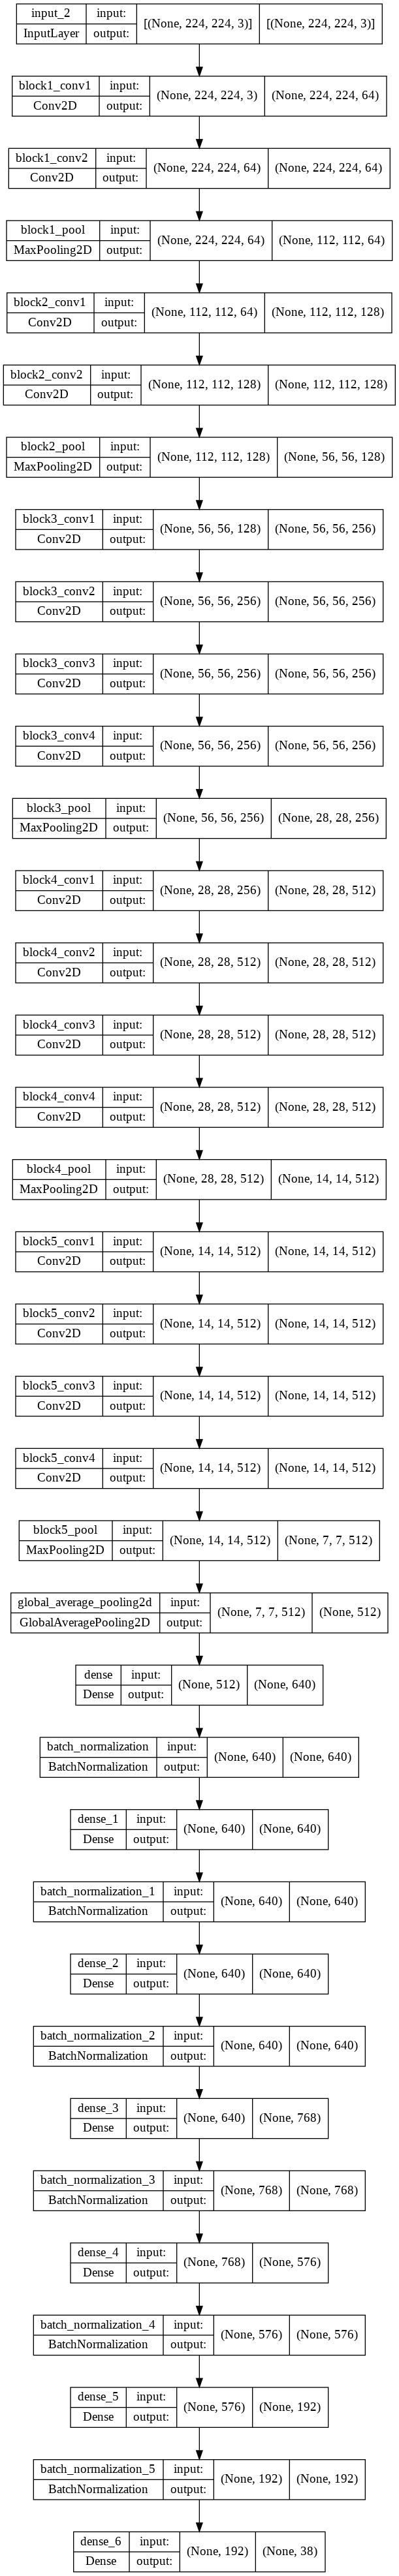

In [ ]:
keras.utils.plot_model(best_model, show_shapes=True)

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 6
units_0: 640
dropout: False
lr: 0.00012104485758566835
units_1: 640
units_2: 640
units_3: 768
units_4: 576
units_5: 192
Score: 0.5613376498222351
Trial summary
Hyperparameters:
num_layers: 6
units_0: 832
dropout: False
lr: 0.00024586773986617026
units_1: 832
units_2: 896
units_3: 512
units_4: 128
units_5: 128
Score: 0.638660728931427
Trial summary
Hyperparameters:
num_layers: 4
units_0: 832
dropout: False
lr: 0.002277975428468371
units_1: 128
units_2: 128
units_3: 128
Score: 0.6868246495723724
Trial summary
Hyperparameters:
num_layers: 4
units_0: 768
dropout: True
lr: 0.0021454536697346786
units_1: 896
units_2: 384
units_3: 832
units_4: 256
units_5: 896
drop_rate_0: 0.0
drop_rate_1: 0.0
drop_rate_2: 0.0
drop_rate_3: 0.0
Score: 0.818832665681839


In [ ]:
history_tl = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=step_size_train,
    batch_size=batch_size,
    validation_steps=step_size_val, 
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/5
1301/1301 [==============================] - 686s 526ms/step - loss: 0.7182 - accuracy: 0.7359 - val_loss: 0.5830 - val_accuracy: 0.8293
Epoch 2/5
1301/1301 [==============================] - 680s 523ms/step - loss: 0.6910 - accuracy: 0.7421 - val_loss: 0.5022 - val_accuracy: 0.8465
Epoch 3/5
1301/1301 [==============================] - 682s 524ms/step - loss: 0.6869 - accuracy: 0.7412 - val_loss: 0.6068 - val_accuracy: 0.8205
Epoch 4/5
1301/1301 [==============================] - 683s 525ms/step - loss: 0.6780 - accuracy: 0.7454 - val_loss: 0.4840 - val_accuracy: 0.8561
Epoch 5/5
1301/1301 [==============================] - 678s 521ms/step - loss: 0.6629 - accuracy: 0.7497 - val_loss: 0.5419 - val_accuracy: 0.8243


In [ ]:
%%time
[loss, acc] = best_model.evaluate(test_generator, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))
print("Test loss:", loss)

Test accuracy: 82.43%
Test loss: 0.5544055104255676
CPU times: user 53.1 s, sys: 6.95 s, total: 1min
Wall time: 1h 26min 19s


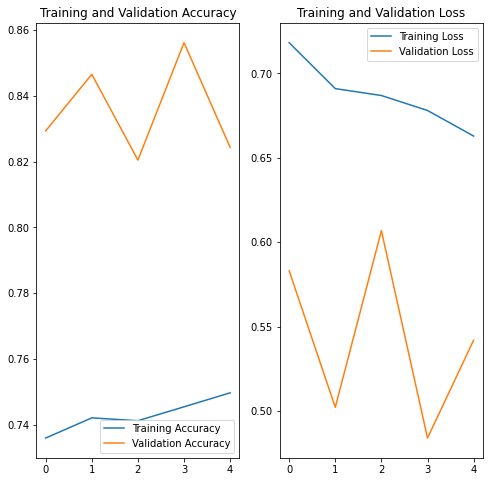

In [ ]:
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

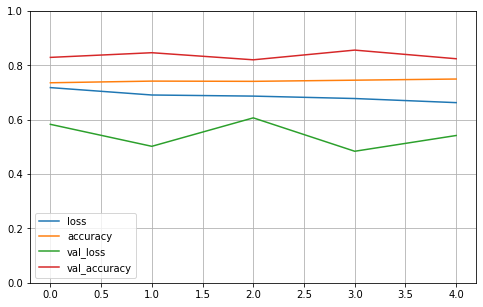

In [ ]:
pd.DataFrame(history_tl.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
layers_to_freeze = 19

for layer in best_model.layers[:layers_to_freeze]:
    layer.trainable=False
for layer in best_model.layers[layers_to_freeze:]:
    layer.trainable=True

In [ ]:
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
best_model.compile(
    loss="categorical_crossentropy",
    optimizer="Adam",
    metrics=["accuracy"]
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, mode='auto')
checkpoint = keras.callbacks.ModelCheckpoint(model_saved_dir, save_best_only=True)

In [ ]:
epochs = 8
batch_size = 32

step_size_train = train_generator.n//train_generator.batch_size
step_size_test = test_generator.n//test_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size

In [ ]:
%%time

history_tl = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=step_size_train,
    batch_size=batch_size,
    validation_steps=step_size_val, 
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/8
1301/1301 [==============================] - 687s 526ms/step - loss: 0.9887 - accuracy: 0.6518 - val_loss: 1.0273 - val_accuracy: 0.6557
Epoch 2/8
1301/1301 [==============================] - 682s 524ms/step - loss: 0.6575 - accuracy: 0.7470 - val_loss: 0.9978 - val_accuracy: 0.6962
Epoch 3/8
1301/1301 [==============================] - 685s 526ms/step - loss: 0.5633 - accuracy: 0.7732 - val_loss: 1.2780 - val_accuracy: 0.6616
Epoch 4/8
1301/1301 [==============================] - 693s 532ms/step - loss: 0.5050 - accuracy: 0.7904 - val_loss: 0.5390 - val_accuracy: 0.7842
Epoch 5/8
1301/1301 [==============================] - 682s 524ms/step - loss: 0.4632 - accuracy: 0.8064 - val_loss: 0.4571 - val_accuracy: 0.7986
Epoch 6/8
1301/1301 [==============================] - 678s 521ms/step - loss: 0.4292 - accuracy: 0.8174 - val_loss: 0.5207 - val_accuracy: 0.8674
Epoch 7/8
1301/1301 [==============================] - 677s 520ms/step - loss: 0.4102 - accuracy: 0.8203 - val_loss: 0

In [ ]:
%%time
[loss, acc] = best_model.evaluate(test_generator, verbose=0)
print("Test accuracy: %.2f%%" % (100 * acc))
print("Test loss:", loss)

Test accuracy: 86.30%
Test loss: 0.4594031274318695
CPU times: user 31.9 s, sys: 2.9 s, total: 34.8 s
Wall time: 39.2 s


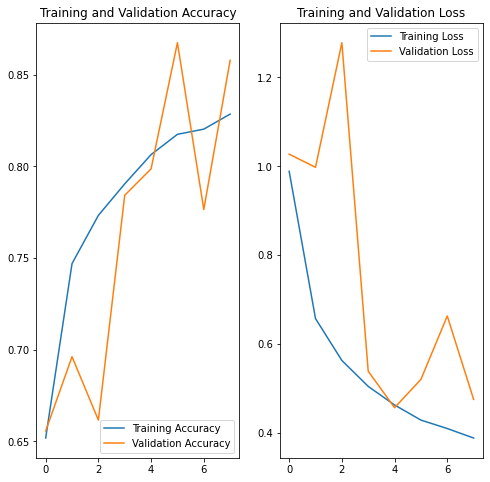

In [ ]:
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

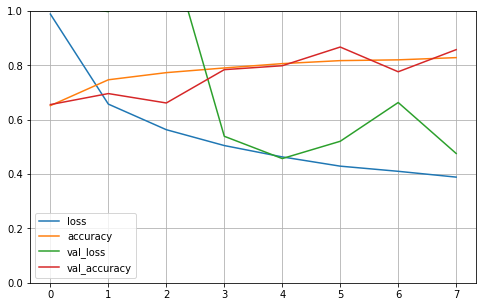

In [ ]:
pd.DataFrame(history_tl.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()